# Analysis and Downstream Tasks

This section runs all downstream analyses, including:
- TVD (Total Variation Distance) calculations  
- MSE and MAE error metrics  
- CellTypist cell type predictions  
- Differential expression analysis  


## 1. MSE and MAE error metrics

#### Compute bulk MAE/MSE between naive and ground truth and also predicted vs ground truth 

In [2]:
import scanpy as sc
import numpy as np

# --- Function Definitions ---
def calculate_mae(actual, predicted):
    """Calculate Mean Absolute Error (MAE) between two arrays."""
    return np.mean(np.abs(actual - predicted))

def calculate_mse(actual, predicted):
    """Calculate Mean Squared Error (MSE) between two arrays."""
    return np.mean((actual - predicted) ** 2)

def f(n_vals, j):
    """Transformation: f(n, 4^j)  4^j * (1 - (1 - 1/4^j)^n)."""
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

i = 12  # Ground truth UMI length (adata_12)
j = 5   # UMI length for comparison


# Ground truth dataset (UMI length 12)
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad")
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")

# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad")
print("Ground Truth adata_12:")
print(adata_12)

# Inverted dataset for model approach (UMI lengths 1-12)
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ur_objects/inverted2_adata_matrices/"


model_dir  = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/"
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/"
adata_dict_model = {idx: sc.read_h5ad(model_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Model Dataset (example adata_dict_model[6]):")
print(adata_dict_model[6])

# Naive dataset (UMI lengths 1-12)
naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/"
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/"
adata_dict_naive = {idx: sc.read_h5ad(naive_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Naive Dataset (example adata_dict_naive[6]):")
print(adata_dict_naive[6])

# --- Compute Bulk MAE for the Model Approach ---
# Use ground truth counts from adata_12 and predicted counts from the model (inverted) dataset at UMI length j.
all_true_model = []
all_pred_model = []

for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        
        # Extract ground truth counts from adata_12 and predicted counts from the model dataset
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_model = adata_dict_model[j].X[idx_j].flatten()
        
        # Only consider genes with counts ≥ 1 and adjust by adding 1 (for log scale)
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] 
        pred_counts = gene_counts_model[mask] 
        
        all_true_model.extend(true_counts)
        all_pred_model.extend(pred_counts)

all_true_model = np.array(all_true_model)
all_pred_model = np.array(all_pred_model)
bulk_mae_model = calculate_mae(all_true_model, all_pred_model)
bulk_mse_model = calculate_mse(all_true_model, all_pred_model)
# print("Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mae_model)


# --- Compute Bulk MAE for the Naive Approach ---
# Use ground truth counts from adata_12 and predicted counts from the naive dataset at UMI length j.
all_true_naive = []
all_naive_pred = []

for barcode in adata_12.obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        
        # Extract ground truth counts from adata_12 and predicted counts from the naive dataset
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_naive = adata_dict_naive[j].X[idx_j].flatten()
        
        # Only consider genes with counts ≥ 1 and adjust by adding 1 (for log scale)
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] 
        naive_counts = gene_counts_naive[mask] 
        
        all_true_naive.extend(true_counts)
        all_naive_pred.extend(naive_counts)

all_true_naive = np.array(all_true_naive)
all_naive_pred = np.array(all_naive_pred)
bulk_mae_naive = calculate_mae(all_true_naive, all_naive_pred)
bulk_mse_naive = calculate_mse(all_true_naive, all_naive_pred)


print("Bulk Naive MAE (Ground Truth adata_12 vs. Naive UMI 5):", bulk_mae_naive)
print("Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mae_model)
percent_change = (bulk_mae_naive - bulk_mae_model)/ bulk_mae_naive
print("Percent Change", percent_change * 100)
print("=======================================================================")

print("Bulk Naive MSE (Ground Truth adata_12 vs. Naive UMI 5):", bulk_mse_naive)
print("Bulk Model MSE (Ground Truth adata_12 vs. Inverted UMI 5):", bulk_mse_model)
percent_change = (bulk_mse_naive - bulk_mse_model)/ bulk_mse_naive 
print("Percent Change", percent_change * 100)


Ground Truth adata_12:
AnnData object with n_obs × n_vars = 1232 × 28226
Model Dataset (example adata_dict_model[6]):
AnnData object with n_obs × n_vars = 1232 × 28226
Naive Dataset (example adata_dict_naive[6]):
AnnData object with n_obs × n_vars = 1232 × 28226
Bulk Naive MAE (Ground Truth adata_12 vs. Naive UMI 5): 0.10638695235109294
Bulk Model MAE (Ground Truth adata_12 vs. Inverted UMI 5): 0.05002175747142818
Percent Change 52.98130422389688
Bulk Naive MSE (Ground Truth adata_12 vs. Naive UMI 5): 155.43933026750406
Bulk Model MSE (Ground Truth adata_12 vs. Inverted UMI 5): 7.384367536213194
Percent Change 95.24935708130945


#### Per-cell MAE and MSE: Naïve vs Model (scatter comparison)

Ground Truth adata_12:
AnnData object with n_obs × n_vars = 1232 × 28226
Model Dataset (inverted), example adata_dict_model[6]:
AnnData object with n_obs × n_vars = 1232 × 28226
Naive Dataset, example adata_dict_naive[6]:
AnnData object with n_obs × n_vars = 1232 × 28226
Per-cell Model MAE Vector:
[0.04241276 0.034528   0.02913269 ... 0.03987178 0.03798206 0.03595877]
Per-cell Model MSE Vector:
[0.08315598 0.09229154 0.07698606 ... 0.34494497 0.07738931 0.05792321]
Per-cell Naive MAE Vector:
[0.06495726 0.04389258 0.03994294 ... 0.05747532 0.05554296 0.04065621]
Per-cell Naive MSE Vector:
[0.61733822 0.56020791 0.82239658 ... 1.95803949 0.4676944  0.2211127 ] 1232
Percent of cells where MSE_Model is better than Naive: 99.43%


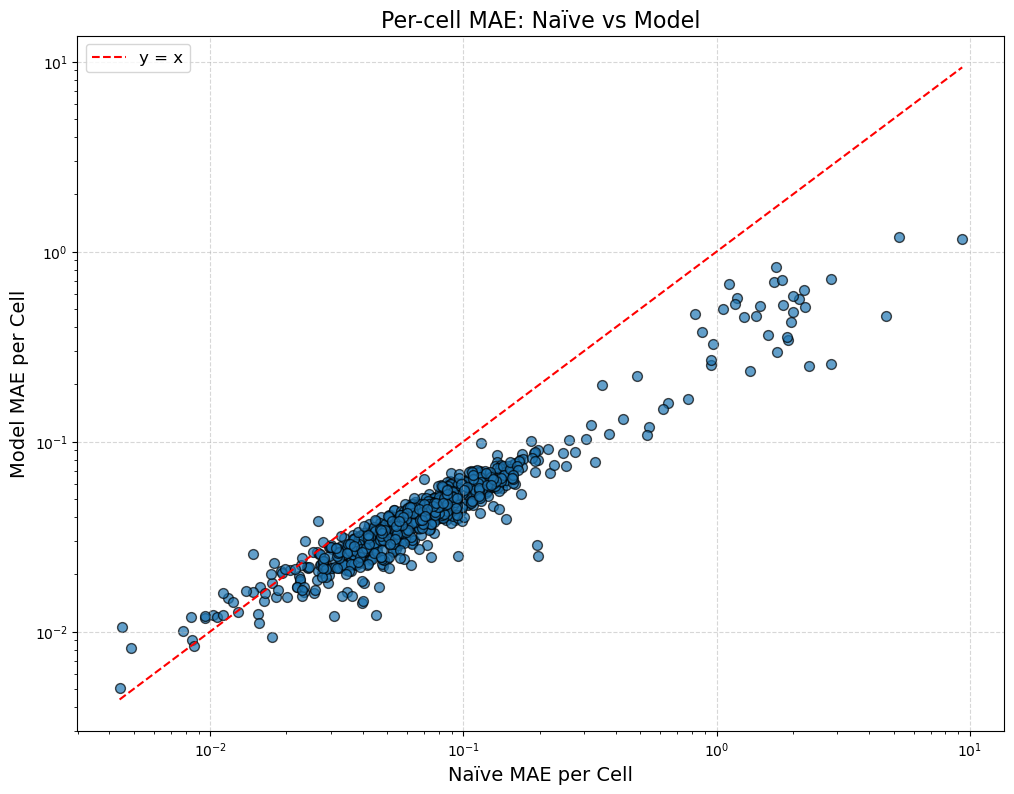

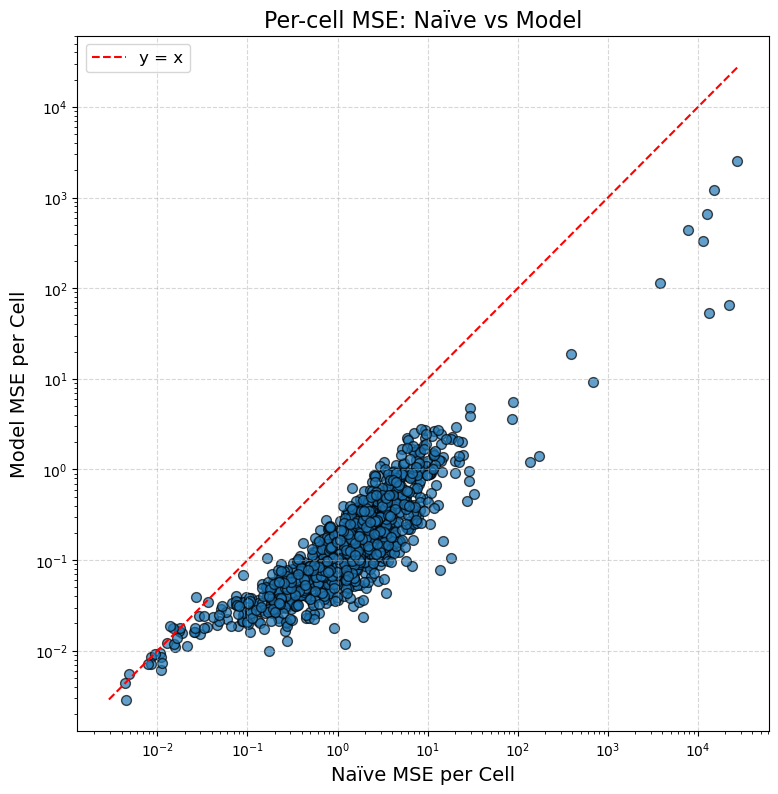

In [3]:
import scanpy as sc
import numpy as np

# --- Function Definitions ---
def calculate_mae(actual, predicted):
    """Calculate Mean Absolute Error (MAE) between two arrays."""
    return np.mean(np.abs(actual - predicted))

def calculate_mse(actual, predicted):
    """Calculate Mean Squared Error (MSE) between two arrays."""
    return np.mean((actual - predicted) ** 2)

def f(n_vals, j):
    """Transformation: f(n, 4^j) = 4^j * (1 - (1 - 1/4^j)^n)."""
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# --- Parameters ---
i = 12  # UMI length for ground truth
j = 5   # UMI length for comparison

# --- Load Datasets ---
# Ground truth dataset (UMI length 12)
adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad") #1k
# adata_12 = sc.read_h5ad("/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/adata_12.h5ad") #10k
print("Ground Truth adata_12:")
print(adata_12)

# Inverted dataset for model MAE and MSE (UMI lengths 1-12)
model_dir  = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/"
# model_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/" #10k
adata_dict_model = {idx: sc.read_h5ad(model_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Model Dataset (inverted), example adata_dict_model[6]:")
print(adata_dict_model[6])

# Naive dataset (UMI lengths 1-12)
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/" #1k
# naive_dir = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/" # 10k
adata_dict_naive = {idx: sc.read_h5ad(naive_dir + f"adata_{idx}.h5ad") for idx in range(1, 13)}
print("Naive Dataset, example adata_dict_naive[6]:")
print(adata_dict_naive[6])

# --- Compute Per-cell MAE for the Model Approach ---
mae_model_vector = []
for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_j = adata_dict_model[j].X[idx_j].flatten()
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1  # Adjust for log scale
        predicted_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        
        mae_model_vector.append(calculate_mae(true_counts, predicted_counts))
mae_model_vector = np.array(mae_model_vector)
print("Per-cell Model MAE Vector:")
print(mae_model_vector)

# --- Compute Per-cell MSE for the Model Approach ---
mse_model_vector = []
for barcode in adata_12.obs_names:
    if barcode in adata_dict_model[j].obs_names:
        idx_12 = np.where(adata_12.obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_model[j].obs_names == barcode)[0][0]
        gene_counts_12 = adata_12.X[idx_12].flatten()
        gene_counts_j = adata_dict_model[j].X[idx_j].flatten()
        mask = gene_counts_12 >= 1
        true_counts = gene_counts_12[mask] + 1  # Adjust for log scale
        predicted_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        
        mse_model_vector.append(calculate_mse(true_counts, predicted_counts))
mse_model_vector = np.array(mse_model_vector)
print("Per-cell Model MSE Vector:")
print(mse_model_vector)

# --- Compute Per-cell MAE for the Naive Approach ---
naive_mae_vector = []
for barcode in adata_dict_naive[i].obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_i = np.where(adata_dict_naive[i].obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        gene_counts_i = adata_dict_naive[i].X[idx_i].flatten()
        gene_counts_j = adata_dict_naive[j].X[idx_j].flatten()
        mask = gene_counts_i >= 1
        true_counts = gene_counts_i[mask] + 1  # Adjust for log scale
        naive_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        naive_mae_vector.append(calculate_mae(true_counts, naive_counts))
naive_mae_vector = np.array(naive_mae_vector)
print("Per-cell Naive MAE Vector:")
print(naive_mae_vector)

# --- Compute Per-cell MSE for the Naive Approach ---
naive_mse_vector = []
for barcode in adata_dict_naive[i].obs_names:
    if barcode in adata_dict_naive[j].obs_names:
        idx_i = np.where(adata_dict_naive[i].obs_names == barcode)[0][0]
        idx_j = np.where(adata_dict_naive[j].obs_names == barcode)[0][0]
        gene_counts_i = adata_dict_naive[i].X[idx_i].flatten()
        gene_counts_j = adata_dict_naive[j].X[idx_j].flatten()
        mask = gene_counts_i >= 1
        true_counts = gene_counts_i[mask] + 1  # Adjust for log scale
        naive_counts = gene_counts_j[mask] + 1  # Adjust for log scale
        naive_mse_vector.append(calculate_mse(true_counts, naive_counts))
naive_mse_vector = np.array(naive_mse_vector)
print("Per-cell Naive MSE Vector:")
print(naive_mse_vector, len(naive_mse_vector))


# --- Calculate Percent of Cells where MSE_Model is Better than MSE_Naive ---
better_model_count = np.sum(mse_model_vector < naive_mse_vector)
total_cells = len(mse_model_vector)
percent_better_model = (better_model_count / total_cells) * 100

print(f"Percent of cells where MSE_Model is better than Naive: {percent_better_model:.2f}%")




import matplotlib.pyplot as plt

# --- MAE Plot ---
plt.figure(figsize=(10, 10))
plt.scatter(naive_mae_vector, mae_model_vector, alpha=0.7, edgecolor='k', s=50)
plt.xlabel("Naïve MAE per Cell", fontsize=14)
plt.ylabel("Model MAE per Cell", fontsize=14)
plt.title("Per-cell MAE: Naïve vs Model", fontsize=16)

# Identity line for reference
min_val = min(naive_mae_vector.min(), mae_model_vector.min())
max_val = max(naive_mae_vector.max(), mae_model_vector.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')

# Save the MAE plot image
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/mae_mse_plots/1k_per_cell_mae_naive_vs_model.pdf")
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/10k_PBMCs/mae_mse_plots/10k_per_cell_mae_naive_vs_model.pdf")
plt.show()

# --- MSE Plot ---
plt.figure(figsize=(10, 10))
plt.scatter(naive_mse_vector, mse_model_vector, alpha=0.7, edgecolor='k', s=50)
plt.xlabel("Naïve MSE per Cell", fontsize=14)
plt.ylabel("Model MSE per Cell", fontsize=14)
plt.title("Per-cell MSE: Naïve vs Model", fontsize=16)

# Identity line for reference
min_val = min(naive_mse_vector.min(), mse_model_vector.min())
max_val = max(naive_mse_vector.max(), mse_model_vector.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.xscale('log')
plt.yscale('log')

# Save the MSE plot image
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/mae_mse_plots/1k_per_cell_mse_naive_vs_model.pdf")
# plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/figures_ur/10k_PBMCs/mae_mse_plots/10k_per_cell_mse_naive_vs_model.pdf")
plt.show()


## 2. Quantify Difference in Gene Expression with MSE

[5.604956516256762e-08, 3.41177577258143e-08, 1.1060657255964294e-08, 1.6499438643742093e-09, 1.8771385372774131e-10, 3.513888666422969e-11, 1.4456378966403582e-11, 8.850357059999024e-12, 6.024021500318063e-12, 3.527022346781407e-12, 1.1332287678600505e-12, 0.0]
[4.9104364189016737e-08, 1.049634713280726e-08, 1.1885310151249734e-09, 2.0698766670500956e-10, 6.070301490281067e-11, 2.4680210918231036e-11, 1.3335481288054599e-11, 8.711554188723031e-12, 6.001645641333817e-12, 3.5165901002537188e-12, 1.1375039627065926e-12, 0.0]


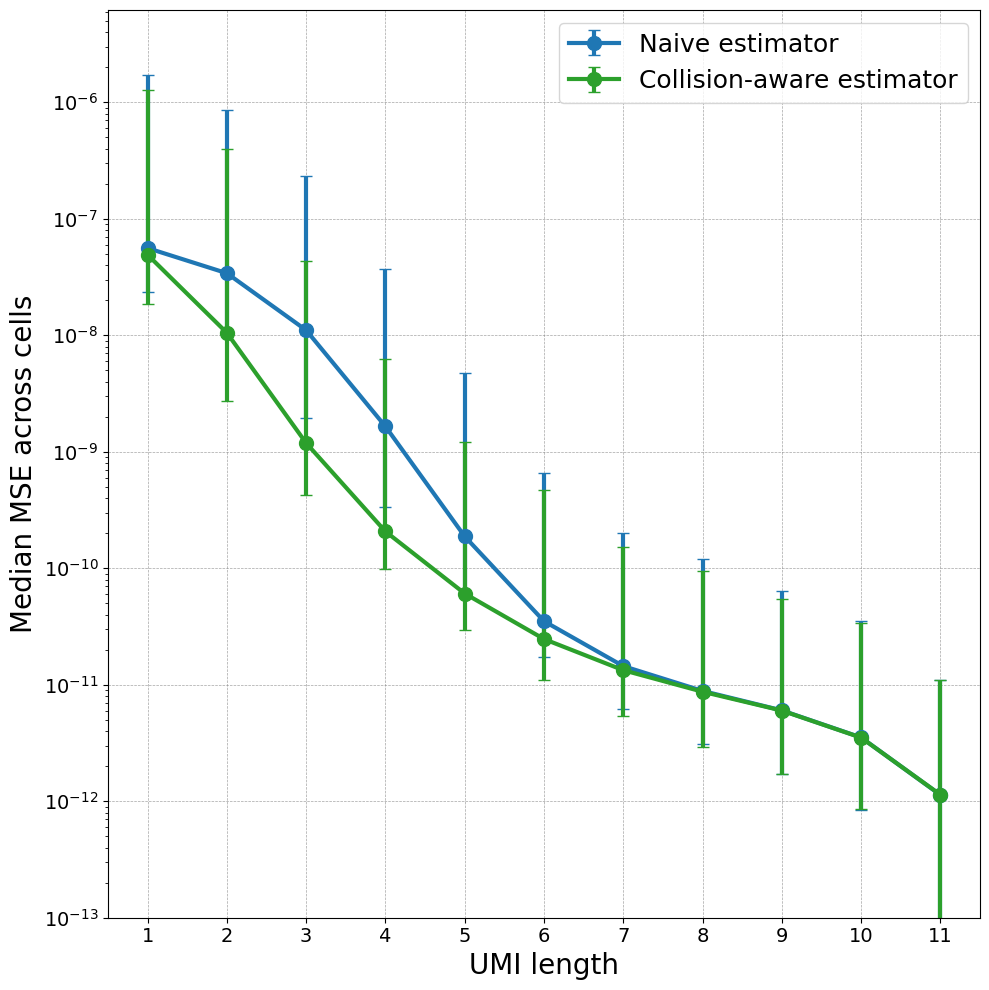

In [10]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
dataset = "1k_PBMCs"  # Change to "10k_PBMCs" for the 10k dataset


remove = np.array(['MALAT1'])  # remove MALAT1

# Loading the regular adata matrices
common_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    regular_adata_dict[i] = adata

# (REMOVED) Loading the collision-aware uniform matrices

# Loading the collision-aware non-uniform matrices  (will become "...2")
common_path3 = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    non_unif_adata_dict[i] = adata
adata = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
non_unif_adata_dict[12] = adata

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the median and (2.5%, 97.5%) CI distances
median_errors, ci_low_errors, ci_high_errors = [], [], []
median_errors2, ci_low_errors2, ci_high_errors2 = [], [], []

# Compute MSE (on row-normalized vectors) for regular and non-uniform matrices against the ground truth
for i in range(1, 13):
    # --- Regular vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in regular_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in regular_adata_dict[i].var_names]
    reg_mat = regular_adata_dict[i][common_cells, common_genes].X
    gt_mat  = gt_adata12[common_cells, common_genes].X
    reg_mat = reg_mat.toarray() if hasattr(reg_mat, "toarray") else np.asarray(reg_mat)
    gt_mat  = gt_mat.toarray()  if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    reg_mat = reg_mat.astype(np.float64, copy=False)
    gt_mat  = gt_mat.astype(np.float64, copy=False)
    # Mask: only genes with GT >= 1
    mask = (gt_mat >= 1.0)
    reg_mat = reg_mat * mask
    gt_mat  = gt_mat  * mask
    # Row-normalize to probabilities
    sum_reg = reg_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    reg_norm = reg_mat / sum_reg
    gt_norm  = gt_mat  / sum_gt
    # Per-row MSE (average across genes), then aggregate
    per_row_mse = np.mean((reg_norm - gt_norm) ** 2, axis=1)
    med = float(np.median(per_row_mse))
    q_low, q_high = np.percentile(per_row_mse, [2.5, 97.5])
    median_errors.append(med)
    ci_low_errors.append(med - q_low)
    ci_high_errors.append(q_high - med)

    # --- Non-uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in non_unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in non_unif_adata_dict[i].var_names]
    nonunif_mat = non_unif_adata_dict[i][common_cells, common_genes].X
    gt_mat      = gt_adata12[common_cells, common_genes].X
    nonunif_mat = nonunif_mat.toarray() if hasattr(nonunif_mat, "toarray") else np.asarray(nonunif_mat)
    gt_mat      = gt_mat.toarray()      if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    nonunif_mat = nonunif_mat.astype(np.float64, copy=False)
    gt_mat      = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    nonunif_mat = nonunif_mat * mask
    gt_mat      = gt_mat      * mask
    sum_non = nonunif_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    nonunif_norm = nonunif_mat / sum_non
    gt_norm      = gt_mat      / sum_gt
    # Per-row MSE (average across genes), then aggregate
    per_row_mse2 = np.mean((nonunif_norm - gt_norm) ** 2, axis=1)
    med2 = float(np.median(per_row_mse2))
    q_low2, q_high2 = np.percentile(per_row_mse2, [2.5, 97.5])
    median_errors2.append(med2)
    ci_low_errors2.append(med2 - q_low2)
    ci_high_errors2.append(q_high2 - med2)

print(median_errors)
print(median_errors2)

# Plotting the errors (median with 2.5%/97.5% CI as asymmetric error bars)
num_experiments = len(median_errors)

plt.figure(figsize=(10, 10))

# Regular (Naive)
plt.errorbar(
    range(1, num_experiments),
    median_errors[:-1],
    yerr=[ci_low_errors[:-1], ci_high_errors[:-1]],
    fmt='o-',
    color='#1f77b4',
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Naive estimator'
)

# Non-uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments),
    median_errors2[:-1],
    yerr=[ci_low_errors2[:-1], ci_high_errors2[:-1]],
    fmt='o-',
    color='#2ca02c',
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware estimator'
)


plt.xlabel('UMI length', fontsize=20)
plt.yscale('log')
plt.ylabel('Median MSE across cells', fontsize=20)
plt.ylim(1e-13)
plt.xticks(range(1, 12), fontsize=14)  # show ticks for 1–11 (since 12 is removed)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()
# plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_naive_nonunif_errors.pdf")
plt.show()

## 3. Differential expression analysis

In [28]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path


### Step 1: Config, data selection, style, and I/O paths

In [29]:
j = 5
dataset = "1k_PBMCs"

if dataset == "10k_PBMCs":
    # Define the cell types of interest for this dataset
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive"]
elif dataset == "10k_PBMCs":
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive", "CD8.Naive"]
elif dataset == "5k_PBMCs":
    CELLS = ["CD14_mono", "NK_16hi", "CD4.Naive", "CD8.Naive"]

METHOD = "wilcoxon"
FC_HI = np.log2(1.25)     # ≈ +0.32
FC_LO = -np.log2(1.25)    # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 10


### Step 2: I/O paths and plot styles

In [30]:
# I/O
GT_PATH  = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE    = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED     = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad"

# Visual style per cell
STYLE_1 = {
    "CD14_mono": {"color": "#1f77b4", "marker": "o", "label": "CD14_mono"},
    "B_naive":   {"color": "#1f77b4", "marker": "o", "label": "B_naive"},
    "CD4.Naive": {"color": "#1f77b4", "marker": "o", "label": "CD4.Naive"},
    "CD8.Naive": {"color": "#1f77b4", "marker": "o", "label": "CD8.Naive"},
    "NK_16hi":  {"color": "#1f77b4", "marker": "o", "label": "NK_16hi"},
}

STYLE_2 = {
    "CD14_mono": {"color": "#2ca02c", "marker": "o", "label": "CD14_mono"},
    "B_naive":   {"color": "#2ca02c", "marker": "o", "label": "B_naive"},
    "CD4.Naive": {"color": "#2ca02c", "marker": "o", "label": "CD4.Naive"},
    "CD8.Naive": {"color": "#2ca02c", "marker": "o", "label": "CD8.Naive"},
    "NK_16hi":  {"color": "#2ca02c", "marker": "o", "label": "NK_16hi"},
}



### Step 3: Sanity checks &  data load 

In [31]:
# Sanity checks up front
for p in [GT_PATH, LAB_PATH, NAIVE, PRED]:
    assert Path(p).exists(), f"Missing file: {p}"

# Load once, reuse
adata_gt    = sc.read_h5ad(GT_PATH)
if "MALAT1" in adata_gt.var_names:   # <<< remove MALAT1
    adata_gt = adata_gt[:, adata_gt.var_names != "MALAT1"].copy()

labels  = sc.read_h5ad(LAB_PATH)

adata_naive = sc.read_h5ad(NAIVE)
if "MALAT1" in adata_naive.var_names:   # <<< remove MALAT1
    adata_naive = adata_naive[:, adata_naive.var_names != "MALAT1"].copy()

adata_pred  = sc.read_h5ad(PRED)
if "MALAT1" in adata_pred.var_names:    # <<< remove MALAT1
    adata_pred = adata_pred[:, adata_pred.var_names != "MALAT1"].copy()

# The big alignment checks
assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

# Normalize the UMI-j matrices
for ad in (adata_naive, adata_pred):
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)


### Step 4: Differential Expression (per cell): build binary labels, run DE (GT/naive/pred), filter genes, and merge

In [32]:
# Precompute average counts from the raw GT matrix
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

rows_naive, rows_pred = [], []
metrics = {}


### Step 5: Compute residuals & metrics; collect plotting rows; finalize metrics table

In [33]:
# Core loop per cell
for cell in CELLS:
    # Binary label: target vs everything else for DE
    reference_labels = labels.obs["majority_voting"].copy()
    binary_labels = reference_labels.apply(lambda x: cell if x == cell else "Other cells")

    # --- GT DE
    adata_12_norm = adata_gt.copy()
    sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
    sc.pp.log1p(adata_12_norm)
    adata_12_norm.obs["label"] = binary_labels.loc[adata_12_norm.obs_names]

    sc.tl.rank_genes_groups(adata_12_norm, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
    de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=cell, key=METHOD)

    # Attach avg counts
    de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    pcol = "pvals_adj" if "pvals_adj" in de_12_avg.columns else "pvals"
    keep_genes = de_12_avg.loc[
        ((de_12_avg["logfoldchanges"] >= FC_HI) | (de_12_avg["logfoldchanges"] <= FC_LO))
        & (de_12_avg[pcol] < PVAL_THRESH)
        & (de_12_avg["avg_count"] >= AVG_COUNT_MIN),
        "names"
    ].astype(str).values

    # --- Naive DE and Pred DE at UMI-j
    adata_naive.obs["label"] = binary_labels.loc[adata_naive.obs_names]
    adata_pred.obs["label"]  = binary_labels.loc[adata_pred.obs_names]

    sc.tl.rank_genes_groups(adata_naive, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
    sc.tl.rank_genes_groups(adata_pred,  groupby="label", method=METHOD, key_added=METHOD, use_raw=False)

    de_naive = sc.get.rank_genes_groups_df(adata_naive, group=cell, key=METHOD)
    de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=cell, key=METHOD)

    de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

    # Filter and merge
    de_12_k    = de_12_avg   [de_12_avg["names"].isin(keep_genes)]
    de_naive_k = de_naive_avg[de_naive_avg["names"].isin(keep_genes)]
    de_pred_k  = de_pred_avg [de_pred_avg["names"].isin(keep_genes)]

    df = (
        de_12_k[["names", "logfoldchanges", "avg_count"]]
        .rename(columns={"logfoldchanges": "lfc_12"})
        .merge(de_naive_k[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_naive"}),
               on="names", how="left", validate="one_to_one")
        .merge(de_pred_k[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_pred"}),
               on="names", how="left", validate="one_to_one")
        .sort_values("avg_count")
        .reset_index(drop=True)
    )

    # Residuals
    df["logrf_naive"] = df["lfc_naive"] - df["lfc_12"]
    df["logrf_pred"]  = df["lfc_pred"]  - df["lfc_12"]

    # Metrics
    se_naive = (df["lfc_naive"].to_numpy() - df["lfc_12"].to_numpy())**2
    se_pred  = (df["lfc_pred" ].to_numpy() - df["lfc_12"].to_numpy())**2

    sse_naive = float(se_naive.sum())  if se_naive.size else np.nan
    sse_pred  = float(se_pred.sum())   if se_pred.size  else np.nan
    mse_naive = float(se_naive.mean()) if se_naive.size else np.nan
    mse_pred  = float(se_pred.mean())  if se_pred.size  else np.nan

    metrics[cell] = {
        "SSE_naive": sse_naive, "MSE_naive": mse_naive,
        "SSE_pred":  sse_pred,  "MSE_pred":  mse_pred,
        "n_genes":   int(df.shape[0])
    }

    # Collect rows
    for avg, v in zip(df["avg_count"], df["logrf_naive"]):
        rows_naive.append({"avg_count": float(avg), "logrf_naive": float(v), "cell": cell})
    for avg, v in zip(df["avg_count"], df["logrf_pred"]):
        rows_pred.append({"avg_count": float(avg), "logrf_pred": float(v), "cell": cell})




#### Step 6: Print metrics & build plot Dataframes

In [34]:
# Print metrics
for c, m in metrics.items():
    print(
        f"{c:<10s} | n={m['n_genes']:4d} | "
        f"SSE naive={m['SSE_naive']:.6f}  MSE naive={m['MSE_naive']:.6f} | "
        f"SSE pred={m['SSE_pred']:.6f}    MSE pred={m['MSE_pred']:.6f}"
    )

# DataFrames
plot_naive = pd.DataFrame(rows_naive)
plot_pred  = pd.DataFrame(rows_pred)




CD14_mono  | n= 110 | SSE naive=0.066689  MSE naive=0.000606 | SSE pred=0.001133    MSE pred=0.000010
B_naive    | n=  98 | SSE naive=0.022427  MSE naive=0.000229 | SSE pred=0.002439    MSE pred=0.000025
CD4.Naive  | n= 106 | SSE naive=0.043028  MSE naive=0.000406 | SSE pred=0.001398    MSE pred=0.000013


### Step 7

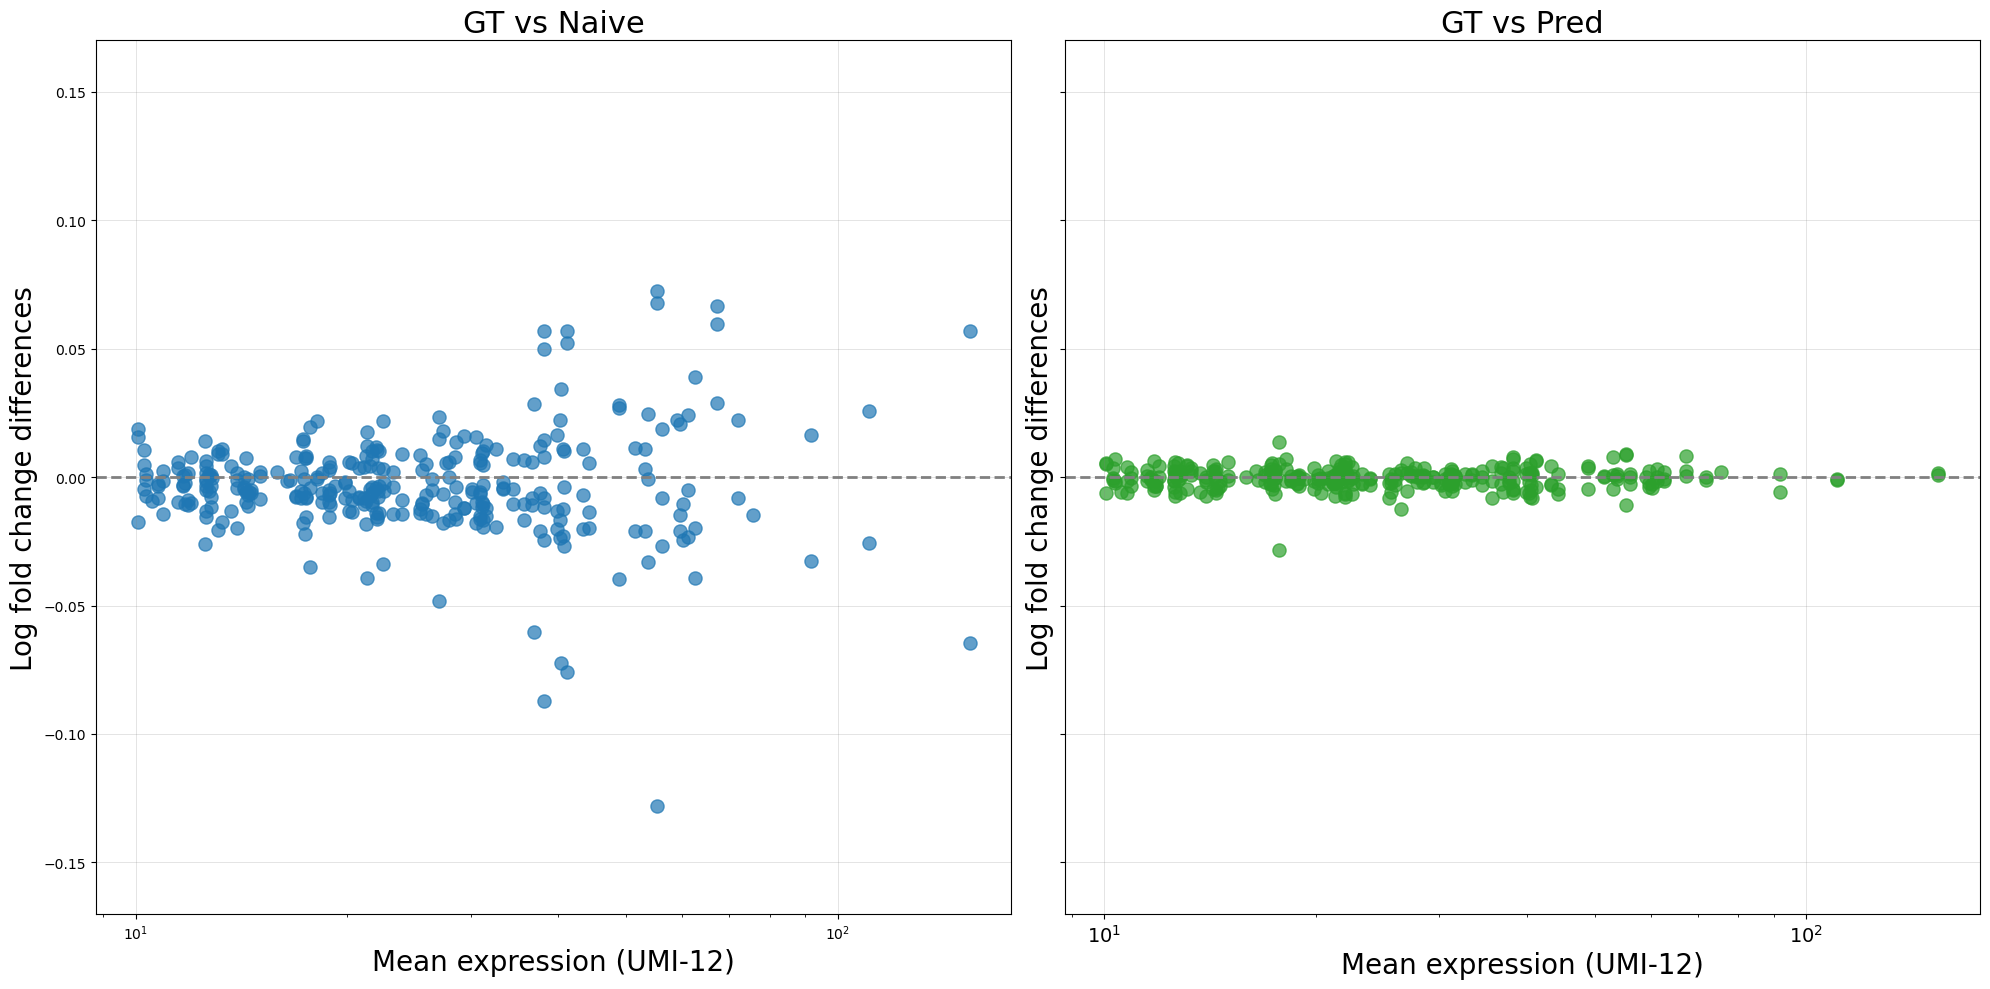

In [36]:
# Step 7 + 8 — Plotting side by side (GT vs Naive and GT vs Pred)

fig, axes = plt.subplots(1, 2, figsize=(20, 10), sharey=True)

# Plot 1: GT vs Naive
ax = axes[0]
for cell in CELLS:
    sub = plot_naive[plot_naive["cell"] == cell]
    if sub.empty:
        continue
    style = STYLE_1[cell]
    ax.scatter(sub["avg_count"], sub["logrf_naive"], alpha=0.7, s=90,
               color=style["color"], marker=style["marker"], label=style["label"])

ax.axhline(0, color="grey", linestyle="--", linewidth=2)
ax.set_xscale("log")
ax.set_xlabel("Mean expression (UMI-12)", fontsize=20)
ax.set_ylabel("Log fold change differences", fontsize=20)
ax.set_ylim(-0.17, 0.17)
ax.grid(True, which="major", linestyle="-", linewidth=0.5, color="gray", alpha=0.3)
ax.set_title("GT vs Naive", fontsize=22)


# Plot 2: GT vs Pred
ax = axes[1]
for cell in CELLS:
    sub = plot_pred[plot_pred["cell"] == cell]
    if sub.empty:
        continue
    style = STYLE_2[cell]
    ax.scatter(sub["avg_count"], sub["logrf_pred"], alpha=0.7, s=90,
               color=style["color"], marker=style["marker"], label=style["label"])

ax.axhline(0, color="grey", linestyle="--", linewidth=2)
ax.set_xscale("log")
ax.set_xlabel("Mean expression (UMI-12)", fontsize=20)
ax.set_ylabel("Log fold change differences", fontsize=20)
ax.set_ylim(-0.17, 0.17)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
ax.grid(True, which="major", linestyle="-", linewidth=0.5, color="gray", alpha=0.3)
ax.set_title("GT vs Pred", fontsize=22)

plt.tight_layout()
plt.show()



### Step 9: Combining all results and computing MSE log fold difference at each UMI length

UMI-1: pooled n=314 | MSE naive=0.789972, MSE pred=0.523313 | SSE naive=248.051, SSE pred=164.32
UMI-2: pooled n=314 | MSE naive=0.254091, MSE pred=0.0268996 | SSE naive=79.7846, SSE pred=8.44649
UMI-3: pooled n=314 | MSE naive=0.0431726, MSE pred=0.000268477 | SSE naive=13.5562, SSE pred=0.0843017
UMI-4: pooled n=314 | MSE naive=0.00458442, MSE pred=5.87579e-05 | SSE naive=1.43951, SSE pred=0.01845
UMI-5: pooled n=314 | MSE naive=0.00042084, MSE pred=1.58313e-05 | SSE naive=0.132144, SSE pred=0.00497103
UMI-6: pooled n=314 | MSE naive=4.48638e-05, MSE pred=6.67625e-06 | SSE naive=0.0140872, SSE pred=0.00209634
UMI-7: pooled n=314 | MSE naive=8.14731e-06, MSE pred=4.20944e-06 | SSE naive=0.00255825, SSE pred=0.00132177
UMI-8: pooled n=314 | MSE naive=3.51142e-06, MSE pred=3.09456e-06 | SSE naive=0.00110259, SSE pred=0.00097169
UMI-9: pooled n=314 | MSE naive=2.89573e-06, MSE pred=2.84253e-06 | SSE naive=0.00090926, SSE pred=0.000892554
UMI-10: pooled n=314 | MSE naive=1.69571e-06, MSE 

/tmp/ipykernel_2807396/2871622655.py:260: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0)


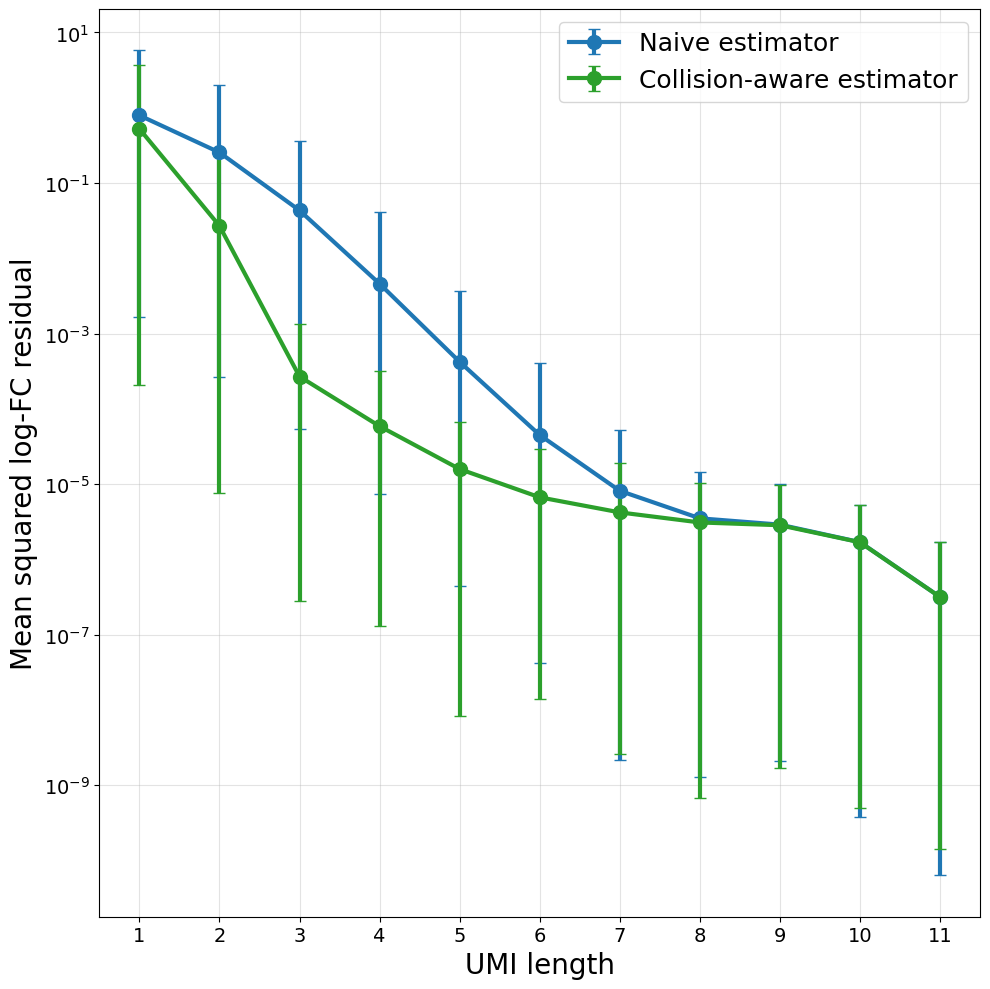

In [37]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path


UMI_MIN, UMI_MAX = 1, 12
dataset = "1k_PBMCs"     # flip to "1k_PBMCs" if needed
METHOD = "wilcoxon"
FC_HI = np.log2(1.25)     # ≈ +0.32
FC_LO = -np.log2(1.25)    # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 10

# Cells to include by dataset (pooled together when computing losses)
if dataset == "1k_PBMCs":
    # Define the cell types of interest for this dataset
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive"]
elif dataset == "10k_PBMCs":
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive", "CD8.Naive"]
elif dataset == "5k_PBMCs":
    CELLS = ["CD14_mono", "NK_16hi", "CD4.Naive", "CD8.Naive"]
else:
    raise ValueError(f"Unknown dataset: {dataset}")

# Paths
ROOT = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}"
GT_PATH  = f"{ROOT}/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = f"{ROOT}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE_FMT = f"{ROOT}/ub_objects/adata_matrices/adata"+"_{j}.h5ad"
PRED_FMT  = f"{ROOT}/ub_objects/col_aware_nunif_matrices/adata"+"_{j}.h5ad"

OUT_DIR = f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
OUT_PDF = f"{OUT_DIR}/{dataset}_MSE_across_UMIs_ALLGENES.pdf"
OUT_CSV = f"{OUT_DIR}/{dataset}_MSE_across_UMIs_ALLGENES.csv"


for p in [GT_PATH, LAB_PATH]:
    assert Path(p).exists(), f"Missing file: {p}"

adata_gt = sc.read_h5ad(GT_PATH)
# --- ONLY CHANGE (drop MALAT1 from GT) ---
if "MALAT1" in adata_gt.var_names:
    adata_gt = adata_gt[:, adata_gt.var_names != "MALAT1"].copy()

labels = sc.read_h5ad(LAB_PATH)

# avg counts from *raw* GT (no log1p)  (now MALAT1-free)
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names.astype(str), "avg_count": avg12})


keep_genes_by_label = {}
binary_labels_by_label = {}
de12_map_by_label = {}

reference_labels = labels.obs["majority_voting"].copy()

for cell in CELLS:
    # Binary labels for this 'cell type vs others'
    binary_labels = reference_labels.apply(lambda x: cell if x == cell else "Other cells")
    binary_labels_by_label[cell] = binary_labels  # store for reuse

    # Normalized/log1p GT copy for DE
    adata_12_norm = adata_gt.copy()
    sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
    sc.pp.log1p(adata_12_norm)
    adata_12_norm.obs["label"] = binary_labels.loc[adata_12_norm.obs_names]

    sc.tl.rank_genes_groups(
        adata_12_norm, groupby="label", method=METHOD, key_added=METHOD, use_raw=False
    )
    de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=cell, key=METHOD)

    # attach avg and filter by GT only
    de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    pcol = "pvals_adj" if "pvals_adj" in de_12_avg.columns else "pvals"

    keep_genes = (
        de_12_avg.loc[
            ((de_12_avg["logfoldchanges"] >= FC_HI) | (de_12_avg["logfoldchanges"] <= FC_LO)) &
            (de_12_avg[pcol] < PVAL_THRESH) &
            (de_12_avg["avg_count"] >= AVG_COUNT_MIN),
            "names"
        ]
        .astype(str)
        .values
    )

    keep_genes_by_label[cell] = set(keep_genes)

    # Keep a compact (gene -> lfc_12) map for this label
    de12_map = de_12[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_12"})
    de12_map["names"] = de12_map["names"].astype(str)
    de12_map_by_label[cell] = de12_map


ks = []
mse_naive, mse_pred = [], []
ci_lo_naive, ci_hi_naive = [], []
ci_lo_pred,  ci_hi_pred  = [], []
sse_naive, sse_pred = [], []
n_points = []

for j in range(UMI_MIN, UMI_MAX + 1):
    naive_path = NAIVE_FMT.format(j=j)
    pred_path  = PRED_FMT.format(j=j)
    if not (Path(naive_path).exists() and Path(pred_path).exists()):
        print(f"Skipping UMI-{j}: missing file(s).")
        continue

    adata_naive = sc.read_h5ad(naive_path)
    # --- ONLY CHANGE (drop MALAT1 from naive) ---
    if "MALAT1" in adata_naive.var_names:
        adata_naive = adata_naive[:, adata_naive.var_names != "MALAT1"].copy()

    adata_pred  = sc.read_h5ad(pred_path)
    # --- ONLY CHANGE (drop MALAT1 from pred) ---
    if "MALAT1" in adata_pred.var_names:
        adata_pred = adata_pred[:, adata_pred.var_names != "MALAT1"].copy()

    # Alignment checks
    assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
    assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
    assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
    assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

    # Normalize/log1p once per matrix
    for ad in (adata_naive, adata_pred):
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)

    # Accumulators across ALL genes at this j
    se_naive_all = []
    se_pred_all  = []

    # Per cell: run DE at UMI-j, restrict to that cell's GT keep set, merge with its GT lfc_12, accumulate SEs
    for cell in CELLS:
        # set labels for this cell
        adata_naive.obs["label"] = binary_labels_by_label[cell].loc[adata_naive.obs_names]
        adata_pred .obs["label"] = binary_labels_by_label[cell].loc[adata_pred.obs_names]

        # DE at UMI-j
        sc.tl.rank_genes_groups(adata_naive, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
        sc.tl.rank_genes_groups(adata_pred,  groupby="label", method=METHOD, key_added=METHOD, use_raw=False)

        de_naive = sc.get.rank_genes_groups_df(adata_naive, group=cell, key=METHOD).copy()
        de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=cell, key=METHOD).copy()

        # Restrict to this label's GT keep set
        keep = keep_genes_by_label[cell]
        if not keep:
            continue

        de_naive = de_naive[de_naive["names"].astype(str).isin(keep)]
        de_pred  = de_pred [de_pred ["names"].astype(str).isin(keep)]

        # Merge with GT lfc_12 for this label; keep only genes present in all
        de12_map = de12_map_by_label[cell]
        df = (
            de12_map.merge(
                de_naive[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_naive"}),
                on="names", how="inner"
            ).merge(
                de_pred[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_pred"}),
                on="names", how="inner"
            )
        )

        if df.empty:
            continue

        # Squared residuals wrt GT
        se_naive = (df["lfc_naive"].to_numpy() - df["lfc_12"].to_numpy()) ** 2
        se_pred_ = (df["lfc_pred" ].to_numpy() - df["lfc_12"].to_numpy()) ** 2

        se_naive_all.append(se_naive)
        se_pred_all.append(se_pred_)

    # Pool across ALL genes for this j
    if len(se_naive_all) == 0:
        print(f"UMI-{j}: no overlapping keep genes across labels; skipping.")
        continue

    se_naive_all = np.concatenate(se_naive_all)
    se_pred_all  = np.concatenate(se_pred_all)

    # MSE and empirical 95% intervals
    mse_n = float(se_naive_all.mean())
    mse_p = float(se_pred_all.mean())

    qn_low, qn_high = np.percentile(se_naive_all, [2.5, 97.5])
    qp_low, qp_high = np.percentile(se_pred_all,  [2.5, 97.5])

    # Store absolute CI bounds (not deltas) for CSV; for plotting we’ll convert to asymmetric yerr
    ci_lo_naive.append(qn_low); ci_hi_naive.append(qn_high)
    ci_lo_pred.append(qp_low);  ci_hi_pred.append(qp_high)

    # SSE (optional)
    sse_n = float(se_naive_all.sum())
    sse_p = float(se_pred_all.sum())

    # Collect
    ks.append(j)
    mse_naive.append(mse_n); mse_pred.append(mse_p)
    sse_naive.append(sse_n); sse_pred.append(sse_p)
    n_points.append(int(se_naive_all.size))  # same size as se_pred_all by construction

    print(f"UMI-{j}: pooled n={se_naive_all.size} | MSE naive={mse_n:.6g}, MSE pred={mse_p:.6g} | SSE naive={sse_n:.6g}, SSE pred={sse_p:.6g}")

# -------------------------
# Plot with asymmetric empirical CIs as error bars
# -------------------------
# Convert CI bounds to asymmetric yerr around the mean
yerr_naive = np.vstack([
    np.array(mse_naive) - np.array(ci_lo_naive),
    np.array(ci_hi_naive) - np.array(mse_naive),
])
yerr_pred = np.vstack([
    np.array(mse_pred) - np.array(ci_lo_pred),
    np.array(ci_hi_pred) - np.array(mse_pred),
])

# Trim out UMI=12 before plotting
plot_idx = [i for i, k in enumerate(ks) if k <= 11]

plot_ks = [ks[i] for i in plot_idx]
plot_mse_naive = [mse_naive[i] for i in plot_idx]
plot_mse_pred  = [mse_pred[i]  for i in plot_idx]

plot_yerr_naive = np.vstack([
    np.array(plot_mse_naive) - np.array([ci_lo_naive[i] for i in plot_idx]),
    np.array([ci_hi_naive[i] for i in plot_idx]) - np.array(plot_mse_naive),
])
plot_yerr_pred = np.vstack([
    np.array(plot_mse_pred) - np.array([ci_lo_pred[i] for i in plot_idx]),
    np.array([ci_hi_pred[i] for i in plot_idx]) - np.array(plot_mse_pred),
])

plt.figure(figsize=(10, 10))
plt.errorbar(
    plot_ks, plot_mse_naive, yerr=plot_yerr_naive, fmt="-o",
    color="#1f77b4", markerfacecolor="#1f77b4", markeredgecolor="#1f77b4",
    capsize=4, markersize=10, linewidth=3, label="Naive estimator"
)
plt.errorbar(
    plot_ks, plot_mse_pred, yerr=plot_yerr_pred, fmt="-o",
    color="#2ca02c", markerfacecolor="#2ca02c", markeredgecolor="#2ca02c",
    capsize=4, markersize=10, linewidth=3, label="Collision-aware estimator"
)

plt.xticks(range(UMI_MIN, 11 + 1), fontsize=14)  # only 1..11
plt.yticks(fontsize=14)
plt.xlabel("UMI length", fontsize=20)
plt.yscale("log")
plt.ylim(0)
plt.ylabel("Mean squared log-FC residual", fontsize=20)
plt.grid(True, linestyle="-", alpha=0.35)
plt.legend(fontsize=18)
plt.tight_layout()
# plt.savefig(OUT_PDF)
plt.show()
# print(f"Saved: {OUT_PDF}")